# Calibration Without Noise Diodes (`calseq`)

This tutorial shows how to use [`GBTFITSLoad.calseq`](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad.calseq) to derive the system temperature for observations taken with the W-Band receiver of the GBT. The W-Band receiver has two feeds (beams) and covers the frequency range from 67 to 92 GHz, and, unlike most of the GBT receivers, it does not have noise diodes for calibration. Instead it uses a wheel to put hot and cold loads in front of the receiver, in what we call a calibration sequence (calseq). For the other spectral line receiver that does not use noise, Argus, the command used to compute the system temperature is [`GBTFITSLoad.vanecal`](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad.vanecal), because Argus uses a vane instead of a wheel. An example showing how to use `vanecal` will be provided elsewhere.

The data in this example contains observations of M82 using the [Nod observing procedure](https://gbtdocs.readthedocs.io/en/latest/references/software/scheduling-blocks.html#astrid_commands.Nod).

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits import GBTFITSLoad
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/nod-W/data/AGBT15B_244_07.raw.vegas.trim.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,130,M82,0.0,CALSEQ,1,87.645,86.4,4,2,3,2,334.378168,46.559458
1,131,M82,0.0,Nod,1,87.645,86.4,4,2,1,2,334.355539,46.497693
2,132,M82,0.0,Nod,2,87.645,86.4,4,2,1,2,334.440019,46.399365
3,133,M82,0.0,Nod,1,87.645,86.4,4,2,1,2,334.281906,46.297948
4,134,M82,0.0,Nod,2,87.645,86.4,4,2,1,2,334.370355,46.199578
5,135,M82,0.0,Nod,1,87.645,86.4,4,2,1,2,334.215247,46.099303
6,136,M82,0.0,Nod,2,87.645,86.4,4,2,1,2,334.306108,46.00088
7,137,M82,0.0,Nod,1,87.645,86.4,4,2,1,2,334.152017,45.900316
8,138,M82,0.0,Nod,2,87.645,86.4,4,2,1,2,334.243761,45.800204
9,139,M82,0.0,Nod,1,87.645,86.4,4,2,1,2,334.092927,45.698204


There are 12 scans in this dataset. Using four spectral windows, two feeds and two polarizations. There are two calseq procedures at the start and end of the observation, and in between a series of five Nod observations.

## Data Reduction

### System Temperature

To calibrate the data we need to know the system temperature during the observations. We use the [`GBTFITSLoad.calseq`](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#dysh.fits.gbtfitsload.GBTFITSLoad.calseq) function to derive the system temperature from the CALSEQ observations. We do this for both feeds, the four spectral windows, and both polarizations.

In [4]:
fdnums = sdfits.udata("FDNUM") # Feeds.
ifnums = sdfits.udata("IFNUM") # Spectral windows.
plnums = sdfits.udata("PLNUM") # Polarizations. 
cscans = [130, 141] # calseq scan numbers.

# Create an array to store the system temperature for each combination.
tsys = np.empty((len(cscans), len(fdnums), len(plnums), len(ifnums)), dtype=float)

# Loop over the combinations.
for s,scan in enumerate(cscans):
    for f,fdnum in enumerate(fdnums):
        for p,plnum in enumerate(plnums):
            for i,ifnum in enumerate(ifnums):
                tsys[s,f,p,i], _ = sdfits.calseq(scan=scan, fdnum=fdnum, plnum=plnum, ifnum=ifnum)

We check how much the system temperature changed between the start and end of the observations. We evaluate this in the form of a percentage relative to the time average of the system temperature.

In [5]:
np.diff(tsys, axis=0)/np.mean(tsys, axis=0)*100

array([[[[2.08003476, 2.02072715, 2.01032736, 1.98261722],
         [2.23027447, 2.34131744, 1.97051881, 1.88567422]],

        [[2.18519033, 2.10316583, 2.0706225 , 2.08775978],
         [2.25817581, 2.19362631, 2.21031971, 2.1263665 ]]]])

From the above we see that the system temperature changed by $\approx2\%$. We will take the mean of the system temperatures as a function of time for the calibration.

In [6]:
tsys = np.mean(tsys, axis=0)

### Nod Calibration

Now we proceed to calibrate the Nod observations. We will use a similar startegy as before, looping over the possible combinations of spectral window, polarization and feeds. However, we will time average the calibrated data, so in the end we will only have one spectrum per spectral window and polarization. Since the data is observed using Nod, the processing will combine the spectra for both beams. The scans we calibrate are all the Nod scans, but we only need to provide the number of one of them per pair, since `dysh` will automatically figure out which scan is the corresponding pair.

The spectra we will save are `Spectrum` objects, so we set the data type, `dtype`, of the array to `object`.

In the call to `GBTFITSLoad.getnod` we must provide a value for the system temperature, one for each beam. In this case, the system temperature for each beam must be in a separate list, like `[[120],[160]]`, where the first feed would use a system temperature of 120 K and the second 160 K. So we take the two system temperatures an pack them into a list or lists before calling the calibration function `getnod`.

In [7]:
nod_ta = np.empty((len(plnums), len(ifnums)), dtype=object)
nod_scans = [131, 133, 135, 137, 139]

for p,plnum in enumerate(plnums):
    for i,ifnum in enumerate(ifnums):
        # Extract the system temperature for both feeds for this polarization and spectral window.
        t_sys = [[t] for t in tsys[:,p,i]]
        # Call the calibration function.
        nod_ta[p,i] = sdfits.getnod(scan=nod_scans, ifnum=ifnum, plnum=plnum, t_sys=t_sys).timeaverage()

### Inspecting the Calibrated Data

Now that we have calibrated our observations, we plot the results to view the calibrated data. We start by plotting things using the built-in plotting functions for `Spectrum` objects, then we proceed to plot the spectra using custom `matplotlib` commands.

In the following cells we will plot one polarization for the individual spectral windows.

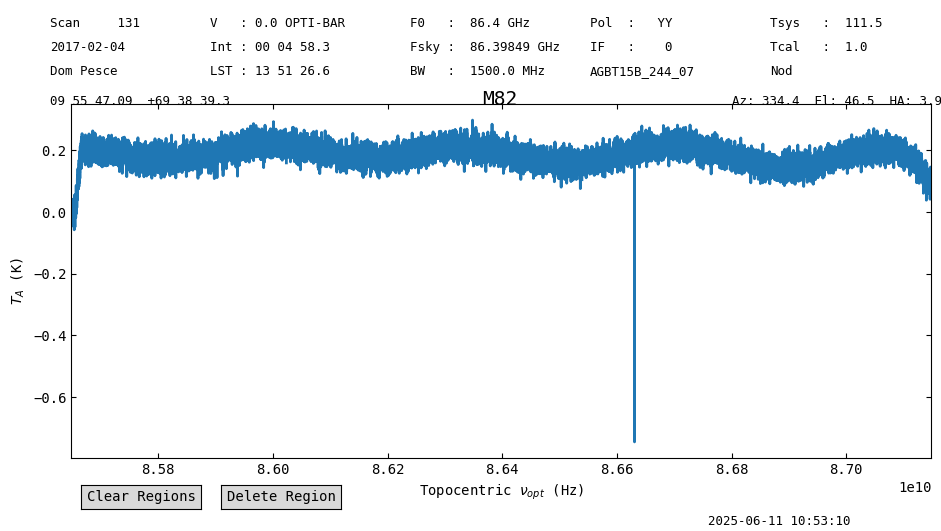

In [8]:
nod_ta[0,0].plot()

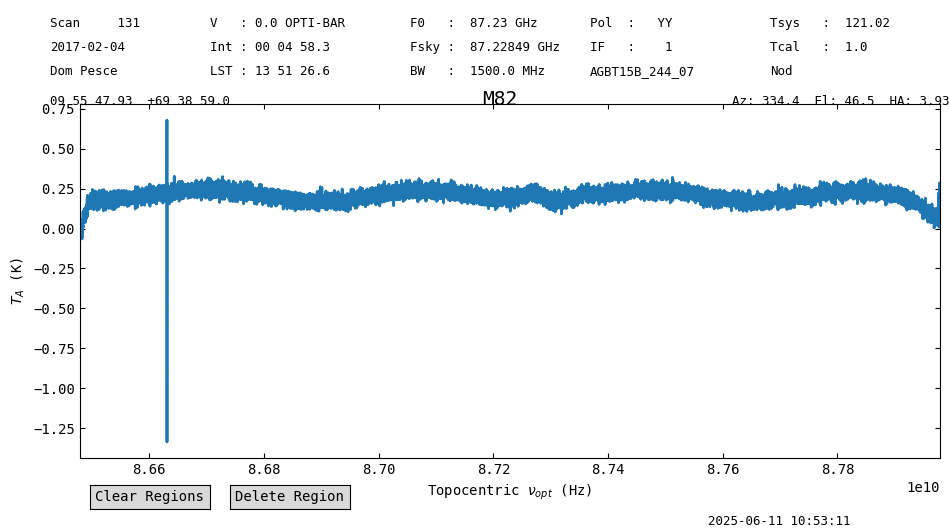

In [9]:
nod_ta[0,1].plot()

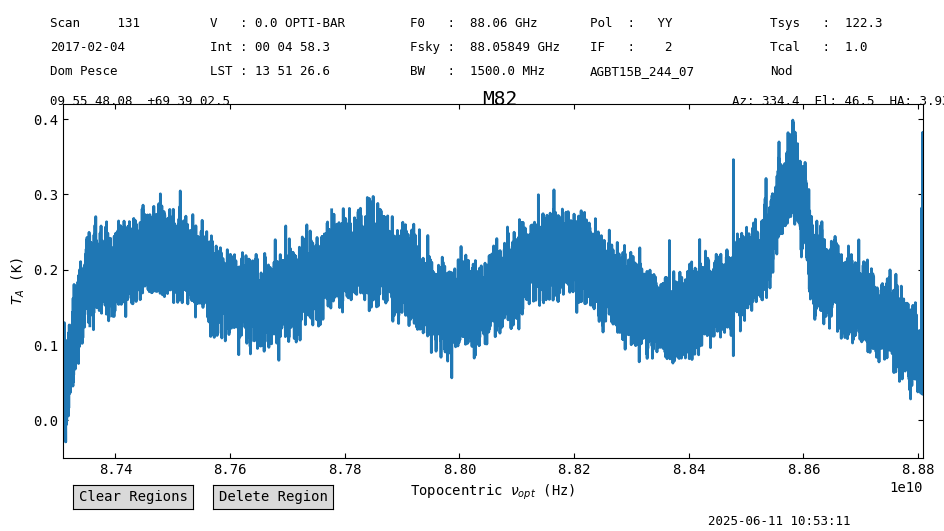

In [10]:
nod_ta[0,2].plot()

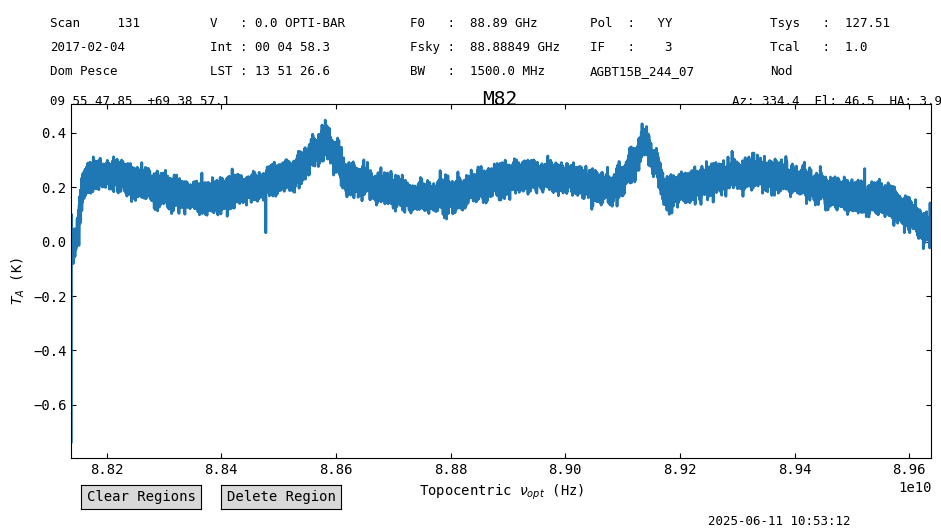

In [11]:
nod_ta[0,3].plot()

Now we will plot all of the spectral windows in a single figure. Since we are using `matplotlib` and it does not know about the units, we must set the labels by hand.

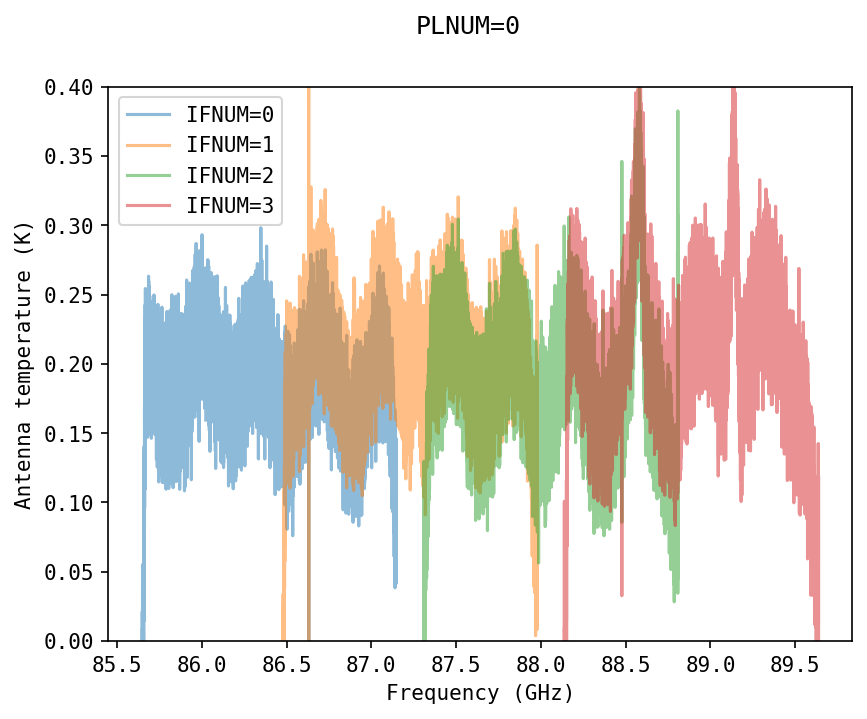

In [12]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=0")
ax = fig.add_subplot(111)
for t in nod_ta[0]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(0, 0.4)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(f"Antenna temperature ({t.flux.unit})");

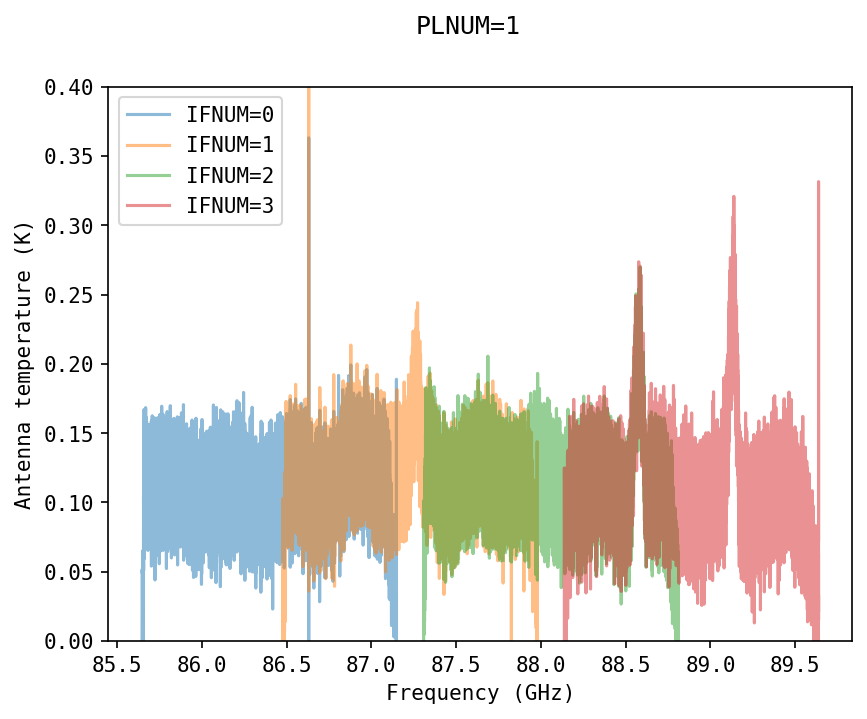

In [13]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=1")
ax = fig.add_subplot(111)
for t in nod_ta[1]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(0, 0.4)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(f"Antenna temperature ({t.flux.unit})");

We see that spectral windows 1, 2 and 3 have strong detections of spectral lines. We focus on these spectral windows from now on.

In [14]:
nod_ta_lines = nod_ta[:,[1,2,3]]

### Baseline Subtraction

Now we proceed to remove the baseline from the spectral windows. For this, we will ignore the channels where we see the spectral lines. The ranges we will ignore are: ifnum=1 from 87.2 to 87.3 GHz, ifnum=2 from 88.5 to 88.7 GHz, and for ifnum=3 from 88.5 to 88.7 and 89 to 89.23 GHz. We will also ignore the first and last 500 channels of each spectra. The exclusion regions must be specified as a list of tuples, like `[(1,10),(50,100)]`, and they can include units as well, however, only one unit per exclusion region is supported. We use an order 15 polynomial as the baseline model. This is a high order, but it captures most of the structure on the spectra for both polarizations.

In [15]:
# Define baseline parameters.
order = 15
model = "poly"
edge = 500
exclude = {1: [(nod_ta_lines[0,0].spectral_axis.quantity.min().to("GHz"), 
                nod_ta_lines[0,0].spectral_axis.quantity[edge].to("GHz")),
               (87.2*u.GHz, 87.3*u.GHz),
               (nod_ta_lines[0,0].spectral_axis.quantity[-edge].to("GHz"), 
                nod_ta_lines[0,0].spectral_axis.quantity.max().to("GHz")),
              ],
           2: [(nod_ta_lines[0,1].spectral_axis.quantity.min().to("GHz"), 
                nod_ta_lines[0,1].spectral_axis.quantity[edge].to("GHz")),
               (88.5*u.GHz, 88.65*u.GHz), 
               (nod_ta_lines[0,1].spectral_axis.quantity[-edge].to("GHz"), 
                nod_ta_lines[0,1].spectral_axis.quantity.max().to("GHz"))
              ],
           3: [(nod_ta_lines[0,2].spectral_axis.quantity.min().to("GHz"), 
                nod_ta_lines[0,2].spectral_axis.quantity[edge].to("GHz")),
               (88.5*u.GHz, 88.7*u.GHz), 
               (89*u.GHz, 89.23*u.GHz),
               (nod_ta_lines[0,2].spectral_axis.quantity[-edge].to("GHz"), 
                nod_ta_lines[0,2].spectral_axis.quantity.max().to("GHz"))
              ],
          }

In [16]:
# Loop over spectra and remove the baseline.
for nod_ta_lines_p in nod_ta_lines:
    for spec in nod_ta_lines_p:
        spec.baseline(order, model=model, exclude=exclude[spec.meta["IFNUM"]], remove=True)

Plot again after removing the baseline.

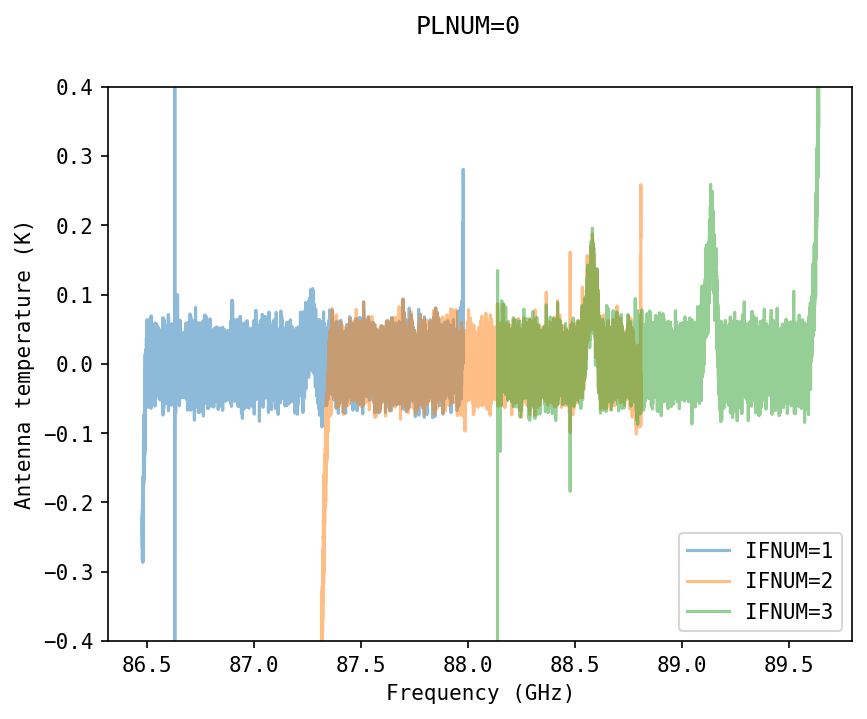

In [17]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=0")
ax = fig.add_subplot(111)
for t in nod_ta_lines[0]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(-0.4, 0.4)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(f"Antenna temperature ({t.flux.unit})");

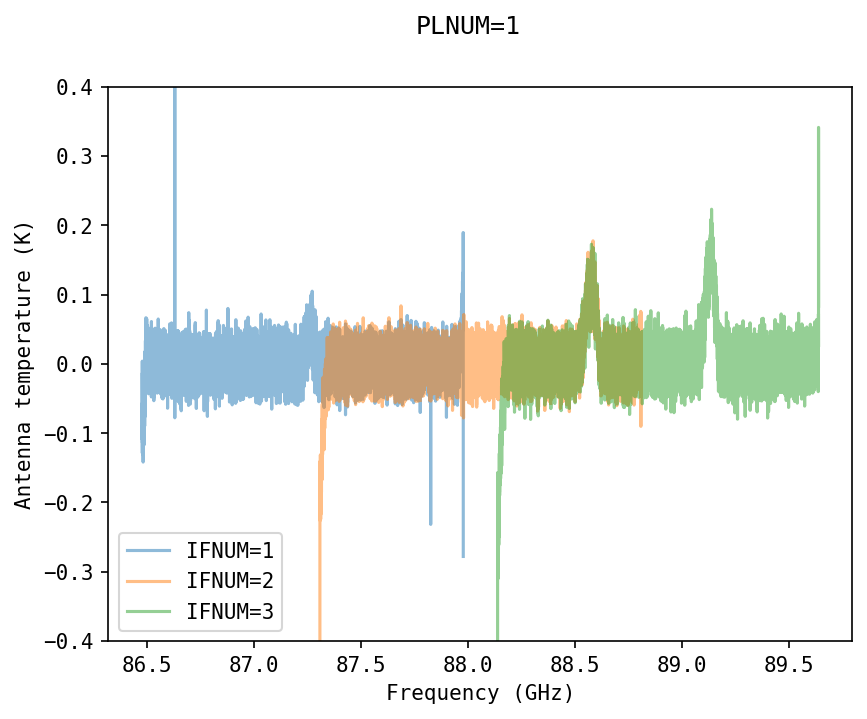

In [18]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=1")
ax = fig.add_subplot(111)
for t in nod_ta_lines[1]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(-0.4, 0.4)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(f"Antenna temperature ({t.flux.unit})");

### Correcting for Atmospheric Opacity

So far the calibrated data has been in the antenna temperature scale, which does not take into account the effects of the atmosphere in the temperature scale. To calibrate taking these effects into account we need to specify an opacity and request a different brightness scale. The scales currently supported by `dysh` are "Ta*" (antenna temperature corrected for atmospheric opacity) and "Jy" (flux density). More details about the calibration can be found in the articles by [Kutner & Ulich (1981)](https://ui.adsabs.harvard.edu/abs/1981ApJ...250..341K/abstract), [Kramer (1997)](https://publicwiki.iram.es/CalibrationPapers?action=AttachFile&do=view&target=kramer_1997_cali_rep.pdf) and [Frayer et al. (2019)](https://library.nrao.edu/public/memos/gbt/GBT_302.pdf).

If you are working inside the GBO network, in one of the [GBO data reduction hosts](https://greenbankobservatory.org/portal/gbt/processing/), then you can use the convenience functions incorporated into `dysh` to retrieve atmospheric opacity.

```Python
from dysh.util.weatherforecast import GBTWeatherForecast
gbwf = GBTWeatherForecast()
spec = nod_ta_lines[0,0]
mjd, freq, tau = gbwf.fetch(vartype="Opacity", 
                            specval=spec.spectral_axis.quantity.mean(), 
                            mjd=spec.obstime.mjd
                           )
```

If you are not working at GBO, then you can follow [these instructions](https://gbtdocs.readthedocs.io/en/latest/how-tos/data_reduction/calculate_opacity.html) to figure out the opacity.

If you do not have access to the GBO computing environment, you can use the [NRAO helpdesk](https://help.nrao.edu/) to ask for opacity values for the GBT. Please specify the dates (accurate to the hour) and frequencies for which you require opacities.

Here we will use the following values, in a dictionary with keys corresponding to the spectral window (IFNUM).

In [19]:
tau = {0: 6.28488304e-02,
       1: 5.99070412e-02,
       2: 5.73315943e-02,
       3: 5.51805677e-02
      }

We repeat the calibration specifying the opacity with the `zenith_opacity` argument and requesting that the data be calibrated to "Ta*" with the `bunit` argument.

In [20]:
nod_ta_star = np.empty((len(plnums), len(ifnums)), dtype=object)
nod_scans = [131, 133, 135, 137, 139]

for p,plnum in enumerate(plnums):
    for i,ifnum in enumerate(ifnums):
        # Extract the system temperature for both feeds for this polarization and spectral window.
        t_sys = [[t] for t in tsys[:,p,i]]
        # Call the calibration function.
        nod_ta_star[p,i] = sdfits.getnod(scan=nod_scans, ifnum=ifnum, plnum=plnum, 
                                         t_sys=t_sys, 
                                         zenith_opacity=tau[ifnum],
                                         bunit="Ta*"
                                        ).timeaverage()

Note: there is a known bug, where the y-axis will still show antenna temperature, $T_{A}$, as the y-axis label even after calibrating to $T_{A}^{*}$. The bug is being tracked [here](https://github.com/GreenBankObservatory/dysh/issues/596). For now, we specify the y-axis label by hand:

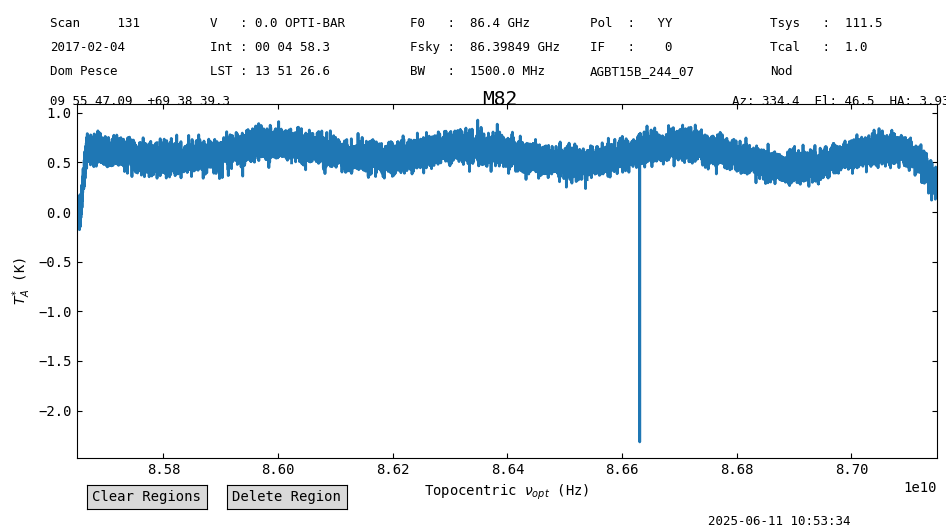

In [21]:
nod_ta_star[0,0].plot(ylabel=r"$T_{A}^{*}$ (K)")

Now we repeat the baseline subtraction on the spectral windows that show emission lines.

In [22]:
nod_ta_star_lines = nod_ta_star[:,[1,2,3]]
for nod_ta_star_lines_p in nod_ta_star_lines:
    for spec in nod_ta_star_lines_p:
        spec.baseline(order, model=model, exclude=exclude[spec.meta["IFNUM"]], remove=True)

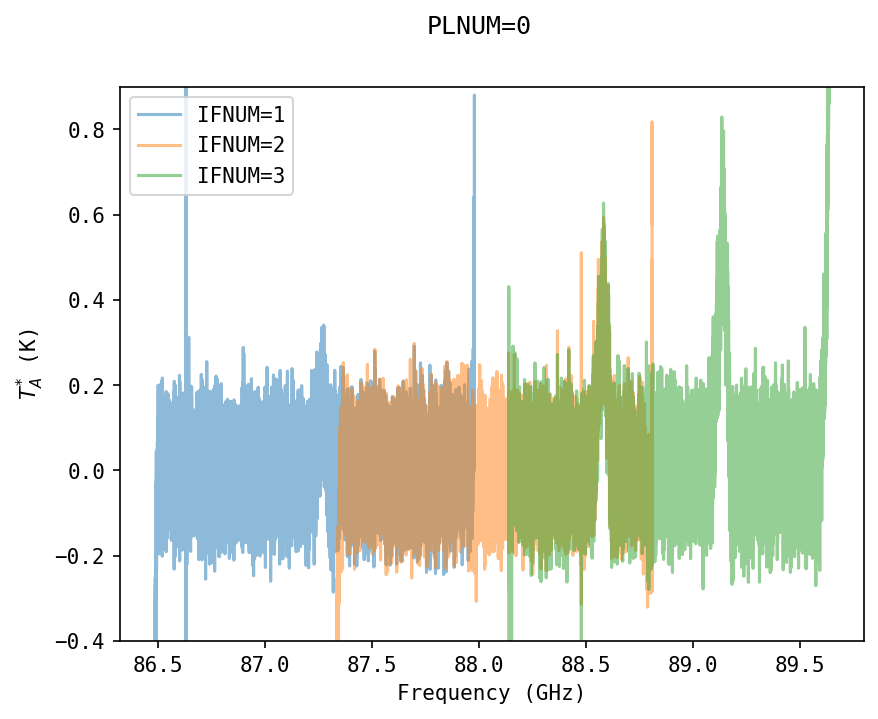

In [23]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=0")
ax = fig.add_subplot(111)
for t in nod_ta_star_lines[0]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(-0.4, 0.9)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(fr"$T_{{A}}^{{*}}$ ({t.flux.unit})");

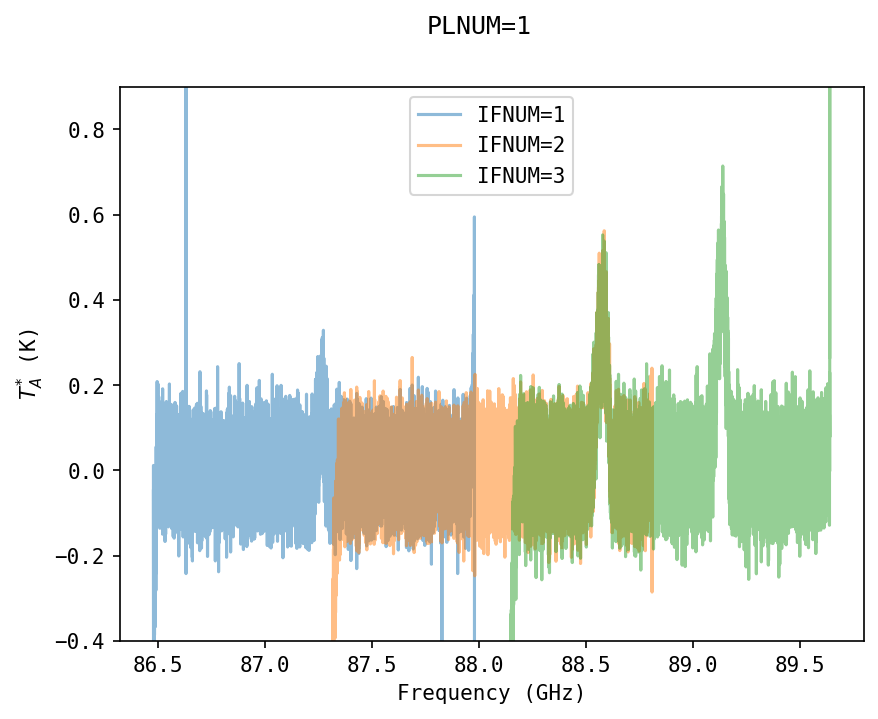

In [24]:
fig = plt.figure(dpi=150)
fig.suptitle("PLNUM=1")
ax = fig.add_subplot(111)
for t in nod_ta_star_lines[1]:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(-0.4, 0.9)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(fr"$T_{{A}}^{{*}}$ ({t.flux.unit})");

### Polarization Average

We are now in a position to average the polarizations. This reduces the noise in the spectra. To average spectra we use the `Spectrum.average` function. It takes as input a list of other `Spectrum` objects. It does not check if the spectra are repeated.

We create a new array `ta_star_pol_ave` where we store the polarization averages, and then we loop over the spectra averaging polarizations.

In [25]:
ta_star_pol_ave = np.empty(nod_ta_star_lines.shape[1], dtype=object)

for i in range(nod_ta_star_lines.shape[1]):
    ta_star_pol_ave[i] = nod_ta_star_lines[0,i].average(nod_ta_star_lines[1,i])

Plot the polarization averages.

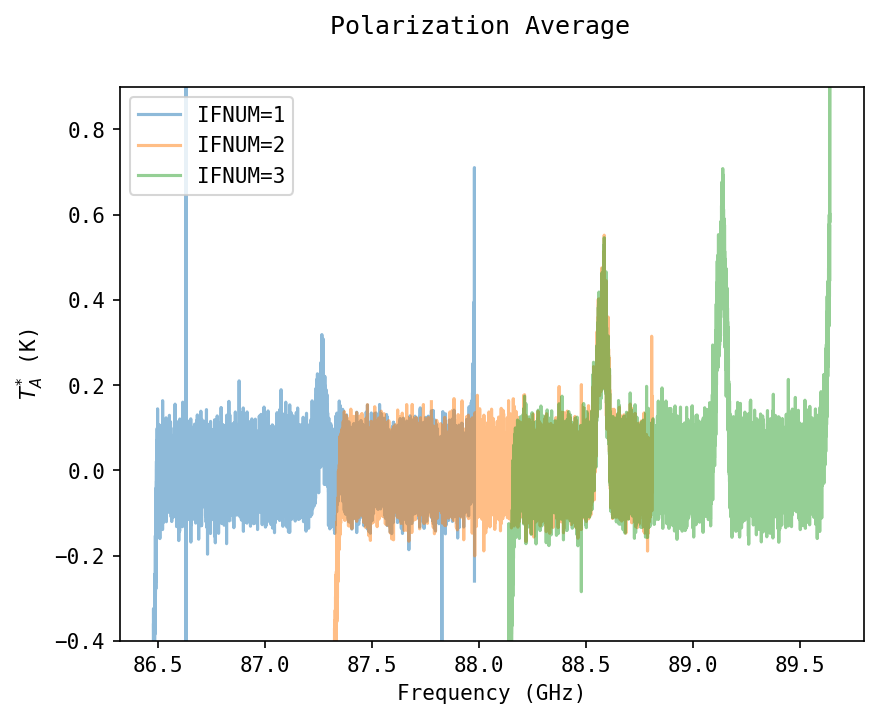

In [26]:
fig = plt.figure(dpi=150)
fig.suptitle("Polarization Average")
ax = fig.add_subplot(111)
for t in ta_star_pol_ave:
    # We need to apply the mask to the data, otherwise it will show as zeros.
    flux = np.ma.masked_where(t.mask, t.flux)
    # Use an alpha of less than one to see the overlapping regions.
    ax.plot(t.spectral_axis.to("GHz"), flux, alpha=0.5, label=f"IFNUM={t.meta['IFNUM']}")
# Show a legend.
ax.legend()
# Limit y-range to focus on data.
ax.set_ylim(-0.4, 0.9)
# Set axis labels by hand.
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel(fr"$T_{{A}}^{{*}}$ ({t.flux.unit})");

## Saving the Calibrated Spectra

Now that we have calibrated our data correcting for atmospheric opacity we save it to FITS files.

First, we create an output directory in the current directory.

In [27]:
products_path = Path.cwd() / "output"
products_path.mkdir(exist_ok=True) 

Now loop over spectral windows saving the data.

In [28]:
for spec in ta_star_pol_ave:
    fnm_out = products_path / f"M82_ifnum_{spec.meta['IFNUM']}_polavg.fits"
    spec.write(fnm_out, format="fits", overwrite=True)

The data is now in FITS tables.

## Loading the Calibrated Spectra

Now that we have saved the calibrated spectra to FITS files, we can read it back in. There are multiple ways of reading back FITS spectra, here we show how to using the built in `dysh` reader `dysh.spectra.Spectrum.read` and `astropy.io.fits` (raw reading).

### Reading with `dysh`

To read a FITS file written by `dysh` we use the `dysh.spectra.Spectrum.read` function. When calling the function we must specify the format of the file, otherwise an error might occur. The following cell will show how to.

In [29]:
from dysh.spectra import Spectrum
read_spec = Spectrum.read(products_path / "M82_ifnum_1_polavg.fits", format="fits")

The result is a `Spectrum` object, with all its capabilities.

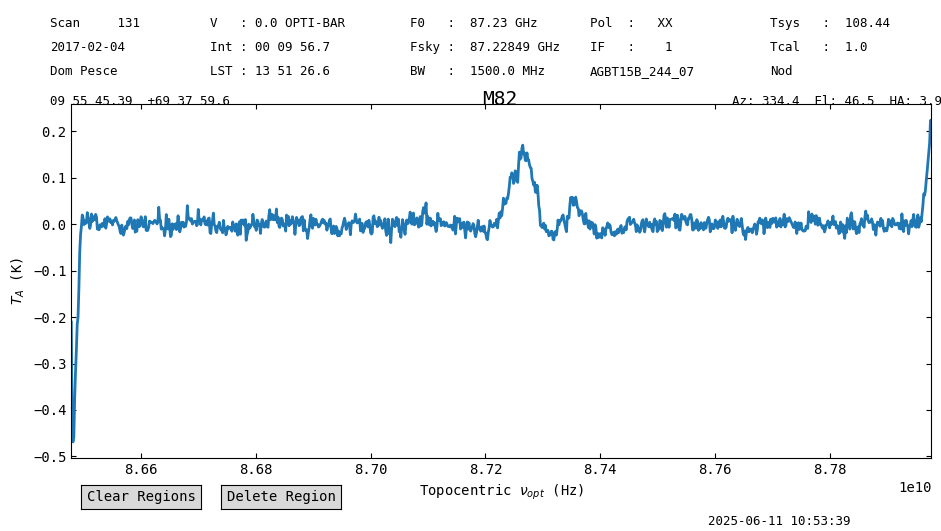

In [30]:
read_spec_smo = read_spec.smooth("gauss", 16)
read_spec_smo.plot()

Even the history is available, albeit not easy to read.

In [31]:
read_spec.history

['2025-06-11T10:53:39-0400 - DYSH v0.6.2 : dysh.spectra.spectrum.Spectrum.__init__(flux=[ 0.         -0.36238663 -0.40867108 ...  0.27896109  0.26013517  -0.25936472] K,wcs=WCS Keywords  Number of WCS axes: 4 CTYPE : \'FREQ\' \'RA\' \'DEC\' \'STOKES\'  CRVAL : 87228489084.0 148.93912373493924 69.63322335271678 -5.0  CRPIX : 8193.0 0.0 0.0 0.0  PC1_1 PC1_2 PC1_3 PC1_4  : 1.0 0.0 0.0 0.0  PC2_1 PC2_2 PC2_3 PC2_4  : 0.0 1.0 0.0 0.0  PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0  PC4_1 PC4_2 PC4_3 PC4_4  : 0.0 0.0 0.0 1.0  CDELT : 91552.734375 1.0 1.0 1.0  NAXIS : 16384  0  0  0,meta=OrderedDict([(\'OBJECT\', \'M82\'), (\'BANDWID\', 1500000000.0), (\'DATE-OBS\', \'2017-02-04T10:11:43.00\'), (\'DURATION\', 60.978172302246094), (\'EXPOSURE\', 596.6629532243182), (\'TSYS\', 108.43573080194732), (\'CTYPE1\', \'FREQ-OBS\'), (\'CRVAL1\', 87228489084.0), (\'CRPIX1\', 8193.0), (\'CDELT1\', 91552.734375), (\'CTYPE2\', \'RA\'), (\'CRVAL2\', 148.93912373493924), (\'CTYPE3\', \'DEC\'), (\'CRVAL3\', 69.63

### Raw Reading

To read the file we use the `astropy.fits.open` function. This will read the FITS file as a data table, not a `Spectrum` object. This makes it more flexible, but it also requires knowledge about how to work with FITS tables.

We start by importing `astropy.fits` and then loading the file.

In [32]:
from astropy.io import fits
hdu = fits.open(products_path / "M82_ifnum_1_polavg.fits")
hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f240c0582b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f240c058850>]

The data is in the second element of the opened file. We can retrieve the header and table data using the `header` and `data` properties.

In [33]:
header = hdu[1].header
data = hdu[1].data
hdu.close() # Close the file for now.

The header contains all the meta data from the `Spectrum`, as well as the data reduction history.

In [34]:
header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =                16384 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'spectral_axis'                                                       
TFORM1  = 'D       '                                                            
TUNIT1  = 'Hz      '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = 'D       '        

In [35]:
header["HISTORY"]

2025-06-11T10:52:22 - Project ID: AGBT15B_244_07
2025-06-11T10:52:22-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.__init__(/home/sandboxes/psalas/Dysh/dysh/notebooks/examples/data/AGB
T15B_244_07.raw.vegas.trim.fits,)
2025-06-11T10:52:22-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:23-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:24-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:25-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:26-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:27-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:28-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:29-0400 - DYSH v0.6.2 : dysh.fits.gbtfitsload.GBTFITSLo
ad.apply_flags()
2025-06-11T10:52:30-0400 - DYSH v0.6.2 : dysh.fits.

The data table contains the spectral axis, flux, mask and other columns which are not used at the moment. For example, if we want to plot the data we can use the following

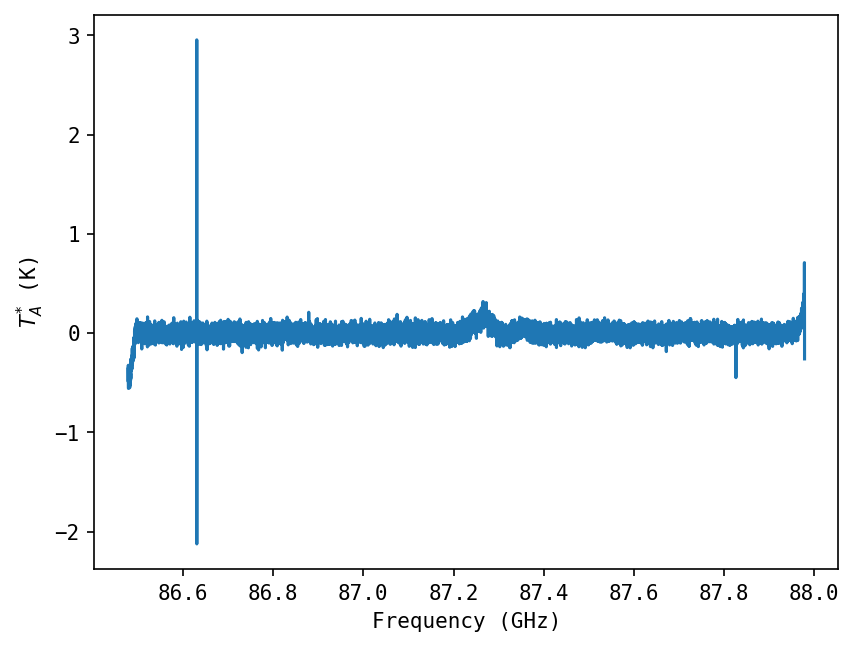

In [36]:
x = data["spectral_axis"]*1e-9 # Convert to GHz.
y = np.ma.masked_where(data["mask"], data["flux"]) # We need to mask the flux values.
plt.figure(dpi=150)
plt.plot(x, y)
plt.ylabel(r"$T_{A}^{*}$ (K)")
plt.xlabel(r"Frequency (GHz)");

# 